In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import Wave2WaveV1
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from deepseries.optim import ReduceCosineAnnealingLR
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error
import chinese_calendar as calendar
import datetime as dt
info = pd.read_excel("../data/info.xlsx")
recored = info.set_index("contributor_id")['huangzf']
info = pd.read_excel("../data/info.xlsx").set_index("contributor_id")[['pjt_name', 'pjt_type']]
norm_score = pd.read_csv(r"../data/20200315_20200415.csv")

In [2]:
power = pd.read_csv('../data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p).iloc[:, 10000:]

In [3]:
is_zero = power.values == 0
is_nan = power.isnull().values
is_valid = ~is_zero & ~is_nan

xy = np.ma.masked_array(power.values, mask=~is_valid)

series_mu = xy.mean(axis=1).data.reshape(-1, 1)
series_std = xy.std(axis=1).data.reshape(-1, 1)
xy = (xy - series_mu) / series_std
xy = xy.filled(0.)

xy = np.expand_dims(xy, 1).astype('float32')

N_TEST = 24 * 31
N_VALID = 24 * 2
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 14
time_free_space = 24

In [4]:
def n_lag(series, n):
    lag = np.zeros_like(series)
    lag[:, :, n:] = series[:, :, :-n]
    return lag

x_lag7 = n_lag(xy, 7 * 24)
x_lag14 = n_lag(xy, 14 * 24)

x_is_valid = np.expand_dims(is_valid, 1)

x_num_features = np.concatenate([x_lag7, x_lag14, x_is_valid], axis=1).astype("float32")

weights = x_is_valid.astype("float32") + 1e-6 
weights = weights * np.expand_dims(series_mu, 2) / series_mu.mean()
weights[:, :, np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)] = \
weights[:, :, np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)] * 0.1

In [5]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)


# xy_weekday = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.weekday.values, 7), axis=0), xy.shape[0], axis=0)

# xy_hour = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.hour.values, 24), axis=0), xy.shape[0], axis=0)

# xy_month = np.repeat(
#     np.expand_dims(
#         periodic_feature(power.columns.month.values, 12), axis=0), xy.shape[0], axis=0)

xy_weekday = pd.get_dummies(power.columns.weekday).T.values
xy_hour = pd.get_dummies(power.columns.hour).T.values
xy_month = pd.get_dummies(power.columns.month).T.values
xy_date = np.concatenate([xy_weekday, xy_hour, xy_month], 0)
xy_date = np.repeat(np.expand_dims(xy_date, 0), xy.shape[0], axis=0)



def get_holiday_features(dts):
    holidays = pd.get_dummies(pd.Series(dts).apply(lambda x: calendar.get_holiday_detail(x)[1]))
    holidays['sick'] = np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)
    return holidays

holidays = get_holiday_features(power.columns)
holidays = np.expand_dims(holidays.values.transpose(1, 0), 0)
holidays = np.repeat(holidays, xy.shape[0], axis=0)

xy_num_features = np.concatenate([
    holidays,
    xy_date
], axis=1).astype('float32')

In [6]:
xy_cat_features = np.expand_dims(np.arange(62), 1)

In [7]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, N_TEST+N_VALID)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, N_TEST)

train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])

train_xy_features = TimeSeries(xy_num_features[:, :, train_idx])
valid_xy_features = TimeSeries(xy_num_features[:, :, valid_idx])

train_x_features = TimeSeries(x_num_features[:, :, train_idx])
valid_x_features = TimeSeries(x_num_features[:, :, valid_idx])

train_xy_cat = Property(xy_cat_features)
valid_xy_cat = Property(xy_cat_features)

train_weight = TimeSeries(weights[:, :, train_idx])
valid_weight = TimeSeries(weights[:, :, valid_idx])

train_frame = Seq2SeqDataLoader(train_xy, batch_size=16, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=24,
                          enc_num_feats=[train_xy_features, train_x_features], dec_num_feats=[train_xy_features], weights=train_weight,
                               enc_cat_feats=[train_xy_cat], dec_cat_feats=[train_xy_cat])
valid_frame = Seq2SeqDataLoader(valid_xy, batch_size=64, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=0,
                         time_interval=48, enc_num_feats=[valid_xy_features, valid_x_features], dec_num_feats=[valid_xy_features],
                               weights=valid_weight, dec_cat_feats=[valid_xy_cat], enc_cat_feats=[valid_xy_cat])

test_xy = xy[:, :, test_idx]
test_xf = np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)
test_yf = xy_num_features[:, :, test_idx]
test_dec_cat = np.repeat(np.expand_dims(xy_cat_features, 2), DEC_LEN, axis=2)
test_enc_cat = np.repeat(np.expand_dims(xy_cat_features, 2), ENC_LEN, axis=2)

In [11]:
model = Wave2WaveV1(enc_num=54, dec_num=51, n_layers=10, n_blocks=2, 
                enc_cat=[(63, 4)], dec_cat=[(63, 4)], dropout=0., debug=False, hidden_size=512)
opt = Adam(model.parameters(), 0.001)
loss_fn = MSELoss()
model.cuda()
lr_scheduler = ReduceCosineAnnealingLR(opt, 64, eta_min=1e-4)
learner = Learner(model, opt, loss_fn, './power_env', verbose=5000, lr_scheduler=None)
learner.fit(500, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

[[04/23/2020 22:16:54]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env/logs
[[04/23/2020 22:16:58]] epoch 1 / 500, batch 100%, train loss 0.3936, valid loss 1.0801, cost 0.1 min
[[04/23/2020 22:17:03]] epoch 2 / 500, batch 100%, train loss 0.1355, valid loss 1.0984, cost 0.1 min
[[04/23/2020 22:17:08]] epoch 3 / 500, batch 100%, train loss 1.7395, valid loss 0.8810, cost 0.1 min
[[04/23/2020 22:17:12]] epoch 4 / 500, batch 100%, train loss 0.7502, valid loss 0.8217, cost 0.1 min
[[04/23/2020 22:17:18]] epoch 5 / 500, batch 100%, train loss 0.5821, valid loss 0.8320, cost 0.1 min
[[04/23/2020 22:17:23]] epoch 6 / 500, batch 100%, train loss 0.3131, valid loss 0.8605, cost 0.1 min
[[04/23/2020 22:17:28]] epoch 7 / 500, batch 100%, train loss 0.6937, valid loss 0.8641, cost 0.1 min
[[04/23/2020 22:17:34]] epoch 8 / 500, batch 100%, train loss 0.7118, valid loss 0.8444, cost 0.1 min
[[04/23/2020 22:17:38]] epoch 9 / 500, batch 100%, train loss 0.4540, valid loss 0.82

[[04/23/2020 22:23:22]] epoch 80 / 500, batch 100%, train loss 0.1905, valid loss 0.4073, cost 0.1 min
[[04/23/2020 22:23:27]] epoch 81 / 500, batch 100%, train loss 0.1048, valid loss 0.3365, cost 0.1 min
[[04/23/2020 22:23:32]] epoch 82 / 500, batch 100%, train loss 0.0732, valid loss 0.3015, cost 0.1 min
[[04/23/2020 22:23:36]] epoch 83 / 500, batch 100%, train loss 0.2971, valid loss 0.3053, cost 0.1 min
[[04/23/2020 22:23:42]] epoch 84 / 500, batch 100%, train loss 0.2898, valid loss 0.3103, cost 0.1 min
[[04/23/2020 22:23:45]] epoch 85 / 500, batch 100%, train loss 0.1396, valid loss 0.3011, cost 0.1 min
[[04/23/2020 22:23:51]] epoch 86 / 500, batch 100%, train loss 0.0733, valid loss 0.2926, cost 0.1 min
[[04/23/2020 22:23:55]] epoch 87 / 500, batch 100%, train loss 0.1072, valid loss 0.2934, cost 0.1 min
[[04/23/2020 22:24:00]] epoch 88 / 500, batch 100%, train loss 0.1102, valid loss 0.3032, cost 0.1 min
[[04/23/2020 22:24:04]] epoch 89 / 500, batch 100%, train loss 0.0566, va

[[04/23/2020 22:29:55]] epoch 159 / 500, batch 100%, train loss 0.0987, valid loss 0.2994, cost 0.1 min
[[04/23/2020 22:30:01]] epoch 160 / 500, batch 100%, train loss 0.1002, valid loss 0.3185, cost 0.1 min
[[04/23/2020 22:30:06]] epoch 161 / 500, batch 100%, train loss 0.1618, valid loss 0.3162, cost 0.1 min
[[04/23/2020 22:30:11]] epoch 162 / 500, batch 100%, train loss 0.1028, valid loss 0.2997, cost 0.1 min
[[04/23/2020 22:30:16]] epoch 163 / 500, batch 100%, train loss 0.1756, valid loss 0.2894, cost 0.1 min
[[04/23/2020 22:30:20]] epoch 164 / 500, batch 100%, train loss 0.5351, valid loss 0.2971, cost 0.1 min
[[04/23/2020 22:30:26]] epoch 165 / 500, batch 100%, train loss 0.1366, valid loss 0.2843, cost 0.1 min
[[04/23/2020 22:30:31]] epoch 166 / 500, batch 100%, train loss 0.2282, valid loss 0.2710, cost 0.1 min
[[04/23/2020 22:30:35]] epoch 167 / 500, batch 100%, train loss 0.3633, valid loss 0.3136, cost 0.1 min
[[04/23/2020 22:30:39]] epoch 168 / 500, batch 100%, train loss 

[[04/23/2020 22:36:38]] epoch 238 / 500, batch 100%, train loss 0.1402, valid loss 0.2888, cost 0.1 min
[[04/23/2020 22:36:44]] epoch 239 / 500, batch 100%, train loss 0.2601, valid loss 0.2644, cost 0.1 min
[[04/23/2020 22:36:49]] epoch 240 / 500, batch 100%, train loss 0.1116, valid loss 0.2751, cost 0.1 min
[[04/23/2020 22:36:54]] epoch 241 / 500, batch 100%, train loss 0.1593, valid loss 0.3115, cost 0.1 min
[[04/23/2020 22:36:59]] epoch 242 / 500, batch 100%, train loss 0.1913, valid loss 0.3255, cost 0.1 min
[[04/23/2020 22:37:05]] epoch 243 / 500, batch 100%, train loss 0.1460, valid loss 0.2760, cost 0.1 min
[[04/23/2020 22:37:09]] epoch 244 / 500, batch 100%, train loss 0.0257, valid loss 0.2764, cost 0.1 min
[[04/23/2020 22:37:15]] epoch 245 / 500, batch 100%, train loss 0.2386, valid loss 0.2741, cost 0.1 min
[[04/23/2020 22:37:19]] epoch 246 / 500, batch 100%, train loss 0.1389, valid loss 0.2697, cost 0.1 min
[[04/23/2020 22:37:24]] epoch 247 / 500, batch 100%, train loss 

[[04/23/2020 22:43:20]] epoch 317 / 500, batch 100%, train loss 0.1242, valid loss 0.3145, cost 0.1 min
[[04/23/2020 22:43:24]] epoch 318 / 500, batch 100%, train loss 0.2112, valid loss 0.2981, cost 0.1 min
[[04/23/2020 22:43:29]] epoch 319 / 500, batch 100%, train loss 0.1550, valid loss 0.2787, cost 0.1 min
[[04/23/2020 22:43:34]] epoch 320 / 500, batch 100%, train loss 0.0505, valid loss 0.2714, cost 0.1 min
[[04/23/2020 22:43:40]] epoch 321 / 500, batch 100%, train loss 0.1034, valid loss 0.2930, cost 0.1 min
[[04/23/2020 22:43:44]] epoch 322 / 500, batch 100%, train loss 0.2576, valid loss 0.2862, cost 0.1 min
[[04/23/2020 22:43:49]] epoch 323 / 500, batch 100%, train loss 0.0638, valid loss 0.2746, cost 0.1 min
[[04/23/2020 22:43:55]] epoch 324 / 500, batch 100%, train loss 0.1914, valid loss 0.2735, cost 0.1 min
[[04/23/2020 22:43:59]] epoch 325 / 500, batch 100%, train loss 0.0520, valid loss 0.2647, cost 0.1 min
[[04/23/2020 22:44:04]] epoch 326 / 500, batch 100%, train loss 

[[04/23/2020 22:49:48]] epoch 396 / 500, batch 100%, train loss 0.0358, valid loss 0.2590, cost 0.1 min
[[04/23/2020 22:49:53]] epoch 397 / 500, batch 100%, train loss 0.1258, valid loss 0.2545, cost 0.1 min
[[04/23/2020 22:49:58]] epoch 398 / 500, batch 100%, train loss 0.5616, valid loss 0.2561, cost 0.1 min
[[04/23/2020 22:50:04]] epoch 399 / 500, batch 100%, train loss 0.2872, valid loss 0.2376, cost 0.1 min
[[04/23/2020 22:50:09]] epoch 400 / 500, batch 100%, train loss 0.0178, valid loss 0.2470, cost 0.1 min
[[04/23/2020 22:50:15]] epoch 401 / 500, batch 100%, train loss 0.1088, valid loss 0.2783, cost 0.1 min
[[04/23/2020 22:50:20]] epoch 402 / 500, batch 100%, train loss 0.0553, valid loss 0.2876, cost 0.1 min
[[04/23/2020 22:50:25]] epoch 403 / 500, batch 100%, train loss 0.0662, valid loss 0.2846, cost 0.1 min
[[04/23/2020 22:50:30]] epoch 404 / 500, batch 100%, train loss 0.0565, valid loss 0.2644, cost 0.1 min
[[04/23/2020 22:50:34]] epoch 405 / 500, batch 100%, train loss 

[[04/23/2020 22:56:15]] epoch 475 / 500, batch 100%, train loss 0.0605, valid loss 0.2914, cost 0.1 min
[[04/23/2020 22:56:19]] epoch 476 / 500, batch 100%, train loss 0.6710, valid loss 0.2575, cost 0.1 min
[[04/23/2020 22:56:23]] epoch 477 / 500, batch 100%, train loss 0.0487, valid loss 0.2521, cost 0.1 min
[[04/23/2020 22:56:28]] epoch 478 / 500, batch 100%, train loss 0.3344, valid loss 0.2523, cost 0.1 min
[[04/23/2020 22:56:33]] epoch 479 / 500, batch 100%, train loss 0.1715, valid loss 0.2731, cost 0.1 min
[[04/23/2020 22:56:37]] epoch 480 / 500, batch 100%, train loss 0.1356, valid loss 0.3210, cost 0.1 min
[[04/23/2020 22:56:42]] epoch 481 / 500, batch 100%, train loss 0.1212, valid loss 0.3494, cost 0.1 min
[[04/23/2020 22:56:47]] epoch 482 / 500, batch 100%, train loss 0.1251, valid loss 0.3438, cost 0.1 min
[[04/23/2020 22:56:53]] epoch 483 / 500, batch 100%, train loss 0.1425, valid loss 0.3369, cost 0.1 min
[[04/23/2020 22:56:58]] epoch 484 / 500, batch 100%, train loss 

In [38]:
opt = Adam(model.parameters(), 0.001)
lr_scheduler = ReduceCosineAnnealingLR(opt, 64, eta_min=5e-5)
learner.lr_scheduler = lr_scheduler
learner.optimizer = opt
learner.fit(3000, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

[[04/24/2020 00:34:30]] start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env/logs
[[04/24/2020 00:34:36]] epoch 927 / 3926, batch 100%, train loss 0.2346, valid loss 0.2675, cost 0.1 min
[[04/24/2020 00:34:40]] epoch 928 / 3926, batch 100%, train loss 0.0998, valid loss 0.2414, cost 0.1 min
[[04/24/2020 00:34:45]] epoch 929 / 3926, batch 100%, train loss 0.1414, valid loss 0.2615, cost 0.1 min
[[04/24/2020 00:34:50]] epoch 930 / 3926, batch 100%, train loss 0.0569, valid loss 0.2695, cost 0.1 min
[[04/24/2020 00:34:55]] epoch 931 / 3926, batch 100%, train loss 0.1700, valid loss 0.2599, cost 0.1 min
[[04/24/2020 00:35:00]] epoch 932 / 3926, batch 100%, train loss 0.0488, valid loss 0.2454, cost 0.1 min
[[04/24/2020 00:35:05]] epoch 933 / 3926, batch 100%, train loss 0.1037, valid loss 0.2453, cost 0.1 min
[[04/24/2020 00:35:10]] epoch 934 / 3926, batch 100%, train loss 0.0716, valid loss 0.2427, cost 0.1 min
[[04/24/2020 00:35:15]] epoch 935 / 3926, batch 100%, train l

[[04/24/2020 00:41:44]] epoch 1005 / 3926, batch 100%, train loss 0.3491, valid loss 0.2292, cost 0.1 min
[[04/24/2020 00:41:50]] epoch 1006 / 3926, batch 100%, train loss 0.2934, valid loss 0.2327, cost 0.1 min
[[04/24/2020 00:41:56]] epoch 1007 / 3926, batch 100%, train loss 0.3007, valid loss 0.2247, cost 0.1 min
[[04/24/2020 00:42:05]] epoch 1008 / 3926, batch 100%, train loss 0.2842, valid loss 0.2275, cost 0.1 min
[[04/24/2020 00:42:13]] epoch 1009 / 3926, batch 100%, train loss 0.1406, valid loss 0.2311, cost 0.1 min
[[04/24/2020 00:42:22]] epoch 1010 / 3926, batch 100%, train loss 0.1770, valid loss 0.2342, cost 0.2 min
[[04/24/2020 00:42:29]] epoch 1011 / 3926, batch 100%, train loss 0.1152, valid loss 0.2326, cost 0.1 min
[[04/24/2020 00:42:39]] epoch 1012 / 3926, batch 100%, train loss 0.3804, valid loss 0.2318, cost 0.2 min
[[04/24/2020 00:42:47]] epoch 1013 / 3926, batch 100%, train loss 0.1783, valid loss 0.2284, cost 0.1 min
[[04/24/2020 00:42:56]] epoch 1014 / 3926, bat

[[04/24/2020 00:49:50]] epoch 1083 / 3926, batch 100%, train loss 0.0952, valid loss 0.2418, cost 0.1 min
[[04/24/2020 00:49:56]] epoch 1084 / 3926, batch 100%, train loss 0.1435, valid loss 0.2443, cost 0.1 min
[[04/24/2020 00:50:00]] epoch 1085 / 3926, batch 100%, train loss 0.2276, valid loss 0.2445, cost 0.1 min
[[04/24/2020 00:50:05]] epoch 1086 / 3926, batch 100%, train loss 0.0843, valid loss 0.2389, cost 0.1 min
[[04/24/2020 00:50:10]] epoch 1087 / 3926, batch 100%, train loss 0.2065, valid loss 0.2356, cost 0.1 min
[[04/24/2020 00:50:15]] epoch 1088 / 3926, batch 100%, train loss 0.0875, valid loss 0.2354, cost 0.1 min
[[04/24/2020 00:50:20]] epoch 1089 / 3926, batch 100%, train loss 0.0971, valid loss 0.2390, cost 0.1 min
[[04/24/2020 00:50:25]] epoch 1090 / 3926, batch 100%, train loss 0.1390, valid loss 0.2395, cost 0.1 min
[[04/24/2020 00:50:30]] epoch 1091 / 3926, batch 100%, train loss 0.2711, valid loss 0.2443, cost 0.1 min
[[04/24/2020 00:50:35]] epoch 1092 / 3926, bat

[[04/24/2020 00:56:27]] epoch 1161 / 3926, batch 100%, train loss 0.0135, valid loss 0.2274, cost 0.1 min
[[04/24/2020 00:56:31]] epoch 1162 / 3926, batch 100%, train loss 0.3039, valid loss 0.2250, cost 0.1 min
[[04/24/2020 00:56:36]] epoch 1163 / 3926, batch 100%, train loss 0.1176, valid loss 0.2347, cost 0.1 min
[[04/24/2020 00:56:41]] epoch 1164 / 3926, batch 100%, train loss 0.1297, valid loss 0.2293, cost 0.1 min
[[04/24/2020 00:56:46]] epoch 1165 / 3926, batch 100%, train loss 0.0854, valid loss 0.2371, cost 0.1 min
[[04/24/2020 00:56:51]] epoch 1166 / 3926, batch 100%, train loss 0.1196, valid loss 0.2401, cost 0.1 min
[[04/24/2020 00:56:55]] epoch 1167 / 3926, batch 100%, train loss 0.1086, valid loss 0.2426, cost 0.1 min
[[04/24/2020 00:56:59]] epoch 1168 / 3926, batch 100%, train loss 0.5371, valid loss 0.2525, cost 0.1 min
[[04/24/2020 00:57:04]] epoch 1169 / 3926, batch 100%, train loss 0.1811, valid loss 0.2415, cost 0.1 min
[[04/24/2020 00:57:10]] epoch 1170 / 3926, bat

[[04/24/2020 01:03:02]] epoch 1239 / 3926, batch 100%, train loss 0.0760, valid loss 0.2371, cost 0.1 min
[[04/24/2020 01:03:07]] epoch 1240 / 3926, batch 100%, train loss 0.0572, valid loss 0.2309, cost 0.1 min
[[04/24/2020 01:03:13]] epoch 1241 / 3926, batch 100%, train loss 0.0736, valid loss 0.2339, cost 0.1 min
[[04/24/2020 01:03:18]] epoch 1242 / 3926, batch 100%, train loss 0.1072, valid loss 0.2286, cost 0.1 min
[[04/24/2020 01:03:23]] epoch 1243 / 3926, batch 100%, train loss 0.0733, valid loss 0.2368, cost 0.1 min
[[04/24/2020 01:03:28]] epoch 1244 / 3926, batch 100%, train loss 0.0711, valid loss 0.2313, cost 0.1 min
[[04/24/2020 01:03:33]] epoch 1245 / 3926, batch 100%, train loss 0.0776, valid loss 0.2316, cost 0.1 min
[[04/24/2020 01:03:38]] epoch 1246 / 3926, batch 100%, train loss 0.2609, valid loss 0.2333, cost 0.1 min
[[04/24/2020 01:03:43]] epoch 1247 / 3926, batch 100%, train loss 0.0655, valid loss 0.2316, cost 0.1 min
[[04/24/2020 01:03:48]] epoch 1248 / 3926, bat

[[04/24/2020 01:09:33]] epoch 1316 / 3926, batch 100%, train loss 0.0290, valid loss 0.2304, cost 0.1 min
[[04/24/2020 01:09:38]] epoch 1317 / 3926, batch 100%, train loss 0.1588, valid loss 0.2350, cost 0.1 min
[[04/24/2020 01:09:43]] epoch 1318 / 3926, batch 100%, train loss 0.1552, valid loss 0.2289, cost 0.1 min
[[04/24/2020 01:09:47]] epoch 1319 / 3926, batch 100%, train loss 0.0589, valid loss 0.2271, cost 0.1 min
[[04/24/2020 01:09:51]] epoch 1320 / 3926, batch 100%, train loss 0.1179, valid loss 0.2279, cost 0.1 min
[[04/24/2020 01:09:55]] epoch 1321 / 3926, batch 100%, train loss 0.1132, valid loss 0.2314, cost 0.1 min
[[04/24/2020 01:10:00]] epoch 1322 / 3926, batch 100%, train loss 0.0395, valid loss 0.2375, cost 0.1 min
[[04/24/2020 01:10:04]] epoch 1323 / 3926, batch 100%, train loss 0.2308, valid loss 0.2424, cost 0.1 min
[[04/24/2020 01:10:09]] epoch 1324 / 3926, batch 100%, train loss 0.3888, valid loss 0.2407, cost 0.1 min
[[04/24/2020 01:10:15]] epoch 1325 / 3926, bat

[[04/24/2020 01:15:56]] epoch 1394 / 3926, batch 100%, train loss 0.2548, valid loss 0.2288, cost 0.1 min
[[04/24/2020 01:16:01]] epoch 1395 / 3926, batch 100%, train loss 0.1976, valid loss 0.2256, cost 0.1 min
[[04/24/2020 01:16:07]] epoch 1396 / 3926, batch 100%, train loss 0.1059, valid loss 0.2271, cost 0.1 min
[[04/24/2020 01:16:12]] epoch 1397 / 3926, batch 100%, train loss 0.0640, valid loss 0.2284, cost 0.1 min
[[04/24/2020 01:16:17]] epoch 1398 / 3926, batch 100%, train loss 0.1892, valid loss 0.2271, cost 0.1 min
[[04/24/2020 01:16:21]] epoch 1399 / 3926, batch 100%, train loss 0.2287, valid loss 0.2318, cost 0.1 min
[[04/24/2020 01:16:27]] epoch 1400 / 3926, batch 100%, train loss 0.1470, valid loss 0.2359, cost 0.1 min
[[04/24/2020 01:16:32]] epoch 1401 / 3926, batch 100%, train loss 0.2869, valid loss 0.2360, cost 0.1 min
[[04/24/2020 01:16:37]] epoch 1402 / 3926, batch 100%, train loss 0.0240, valid loss 0.2345, cost 0.1 min
[[04/24/2020 01:16:43]] epoch 1403 / 3926, bat

[[04/24/2020 01:22:35]] epoch 1472 / 3926, batch 100%, train loss 0.1136, valid loss 0.2298, cost 0.1 min
[[04/24/2020 01:22:40]] epoch 1473 / 3926, batch 100%, train loss 0.1125, valid loss 0.2279, cost 0.1 min
[[04/24/2020 01:22:45]] epoch 1474 / 3926, batch 100%, train loss 0.1543, valid loss 0.2254, cost 0.1 min
[[04/24/2020 01:22:50]] epoch 1475 / 3926, batch 100%, train loss 0.1456, valid loss 0.2308, cost 0.1 min
[[04/24/2020 01:22:56]] epoch 1476 / 3926, batch 100%, train loss 0.3070, valid loss 0.2254, cost 0.1 min
[[04/24/2020 01:23:01]] epoch 1477 / 3926, batch 100%, train loss 0.0171, valid loss 0.2310, cost 0.1 min
[[04/24/2020 01:23:07]] epoch 1478 / 3926, batch 100%, train loss 0.1543, valid loss 0.2255, cost 0.1 min
[[04/24/2020 01:23:11]] epoch 1479 / 3926, batch 100%, train loss 0.1204, valid loss 0.2354, cost 0.1 min
[[04/24/2020 01:23:17]] epoch 1480 / 3926, batch 100%, train loss 0.0742, valid loss 0.2299, cost 0.1 min
[[04/24/2020 01:23:20]] epoch 1481 / 3926, bat

[[04/24/2020 01:28:57]] epoch 1550 / 3926, batch 100%, train loss 0.0424, valid loss 0.2264, cost 0.1 min
[[04/24/2020 01:29:03]] epoch 1551 / 3926, batch 100%, train loss 0.0469, valid loss 0.2332, cost 0.1 min
[[04/24/2020 01:29:08]] epoch 1552 / 3926, batch 100%, train loss 0.0676, valid loss 0.2260, cost 0.1 min
[[04/24/2020 01:29:13]] epoch 1553 / 3926, batch 100%, train loss 0.1421, valid loss 0.2316, cost 0.1 min
[[04/24/2020 01:29:19]] epoch 1554 / 3926, batch 100%, train loss 0.5591, valid loss 0.2527, cost 0.1 min
[[04/24/2020 01:29:25]] epoch 1555 / 3926, batch 100%, train loss 0.1793, valid loss 0.2588, cost 0.1 min
[[04/24/2020 01:29:30]] epoch 1556 / 3926, batch 100%, train loss 0.0538, valid loss 0.2691, cost 0.1 min
[[04/24/2020 01:29:35]] epoch 1557 / 3926, batch 100%, train loss 0.2200, valid loss 0.2522, cost 0.1 min
[[04/24/2020 01:29:40]] epoch 1558 / 3926, batch 100%, train loss 0.0777, valid loss 0.2268, cost 0.1 min
[[04/24/2020 01:29:44]] epoch 1559 / 3926, bat

[[04/24/2020 01:35:39]] epoch 1628 / 3926, batch 100%, train loss 0.2083, valid loss 0.2187, cost 0.1 min
[[04/24/2020 01:35:43]] epoch 1629 / 3926, batch 100%, train loss 0.0459, valid loss 0.2176, cost 0.1 min
[[04/24/2020 01:35:47]] epoch 1630 / 3926, batch 100%, train loss 0.1376, valid loss 0.2240, cost 0.1 min
[[04/24/2020 01:35:52]] epoch 1631 / 3926, batch 100%, train loss 0.0461, valid loss 0.2188, cost 0.1 min
[[04/24/2020 01:35:57]] epoch 1632 / 3926, batch 100%, train loss 0.6030, valid loss 0.2198, cost 0.1 min
[[04/24/2020 01:36:02]] epoch 1633 / 3926, batch 100%, train loss 0.1471, valid loss 0.2168, cost 0.1 min
[[04/24/2020 01:36:07]] epoch 1634 / 3926, batch 100%, train loss 0.5503, valid loss 0.2236, cost 0.1 min
[[04/24/2020 01:36:11]] epoch 1635 / 3926, batch 100%, train loss 0.1534, valid loss 0.2187, cost 0.1 min
[[04/24/2020 01:36:17]] epoch 1636 / 3926, batch 100%, train loss 0.7461, valid loss 0.2242, cost 0.1 min
[[04/24/2020 01:36:22]] epoch 1637 / 3926, bat

[[04/24/2020 01:42:19]] epoch 1706 / 3926, batch 100%, train loss 0.1535, valid loss 0.2211, cost 0.1 min
[[04/24/2020 01:42:24]] epoch 1707 / 3926, batch 100%, train loss 0.1422, valid loss 0.2253, cost 0.1 min
[[04/24/2020 01:42:29]] epoch 1708 / 3926, batch 100%, train loss 0.0589, valid loss 0.2378, cost 0.1 min
[[04/24/2020 01:42:34]] epoch 1709 / 3926, batch 100%, train loss 0.1632, valid loss 0.2362, cost 0.1 min
[[04/24/2020 01:42:39]] epoch 1710 / 3926, batch 100%, train loss 0.2149, valid loss 0.2344, cost 0.1 min
[[04/24/2020 01:42:44]] epoch 1711 / 3926, batch 100%, train loss 0.1017, valid loss 0.2375, cost 0.1 min
[[04/24/2020 01:42:49]] epoch 1712 / 3926, batch 100%, train loss 0.4842, valid loss 0.2281, cost 0.1 min
[[04/24/2020 01:42:53]] epoch 1713 / 3926, batch 100%, train loss 0.1909, valid loss 0.2271, cost 0.1 min
[[04/24/2020 01:42:59]] epoch 1714 / 3926, batch 100%, train loss 0.0509, valid loss 0.2230, cost 0.1 min
[[04/24/2020 01:43:05]] epoch 1715 / 3926, bat

[[04/24/2020 01:50:15]] epoch 1784 / 3926, batch 100%, train loss 0.0782, valid loss 0.2185, cost 0.1 min
[[04/24/2020 01:50:22]] epoch 1785 / 3926, batch 100%, train loss 0.0751, valid loss 0.2210, cost 0.1 min
[[04/24/2020 01:50:30]] epoch 1786 / 3926, batch 100%, train loss 0.1061, valid loss 0.2183, cost 0.1 min
[[04/24/2020 01:50:37]] epoch 1787 / 3926, batch 100%, train loss 0.4306, valid loss 0.2175, cost 0.1 min
[[04/24/2020 01:50:45]] epoch 1788 / 3926, batch 100%, train loss 0.1250, valid loss 0.2194, cost 0.1 min
[[04/24/2020 01:50:53]] epoch 1789 / 3926, batch 100%, train loss 0.0486, valid loss 0.2240, cost 0.1 min
[[04/24/2020 01:51:00]] epoch 1790 / 3926, batch 100%, train loss 0.0858, valid loss 0.2202, cost 0.1 min
[[04/24/2020 01:51:09]] epoch 1791 / 3926, batch 100%, train loss 0.1421, valid loss 0.2162, cost 0.1 min
[[04/24/2020 01:51:16]] epoch 1792 / 3926, batch 100%, train loss 0.4822, valid loss 0.2183, cost 0.1 min
[[04/24/2020 01:51:24]] epoch 1793 / 3926, bat

[[04/24/2020 01:57:20]] epoch 1862 / 3926, batch 100%, train loss 0.1605, valid loss 0.2190, cost 0.1 min
[[04/24/2020 01:57:24]] epoch 1863 / 3926, batch 100%, train loss 0.1697, valid loss 0.2222, cost 0.1 min
[[04/24/2020 01:57:29]] epoch 1864 / 3926, batch 100%, train loss 0.1556, valid loss 0.2151, cost 0.1 min
[[04/24/2020 01:57:35]] epoch 1865 / 3926, batch 100%, train loss 0.2076, valid loss 0.2227, cost 0.1 min
[[04/24/2020 01:57:39]] epoch 1866 / 3926, batch 100%, train loss 0.2306, valid loss 0.2181, cost 0.1 min
[[04/24/2020 01:57:45]] epoch 1867 / 3926, batch 100%, train loss 0.3556, valid loss 0.2176, cost 0.1 min
[[04/24/2020 01:57:49]] epoch 1868 / 3926, batch 100%, train loss 0.2067, valid loss 0.2209, cost 0.1 min
[[04/24/2020 01:57:54]] epoch 1869 / 3926, batch 100%, train loss 0.0794, valid loss 0.2202, cost 0.1 min
[[04/24/2020 01:58:00]] epoch 1870 / 3926, batch 100%, train loss 0.0798, valid loss 0.2200, cost 0.1 min
[[04/24/2020 01:58:05]] epoch 1871 / 3926, bat

[[04/24/2020 02:03:59]] epoch 1940 / 3926, batch 100%, train loss 0.2671, valid loss 0.2149, cost 0.1 min
[[04/24/2020 02:04:03]] epoch 1941 / 3926, batch 100%, train loss 0.2998, valid loss 0.2205, cost 0.1 min
[[04/24/2020 02:04:08]] epoch 1942 / 3926, batch 100%, train loss 0.0957, valid loss 0.2248, cost 0.1 min
[[04/24/2020 02:04:12]] epoch 1943 / 3926, batch 100%, train loss 0.2017, valid loss 0.2233, cost 0.1 min
[[04/24/2020 02:04:17]] epoch 1944 / 3926, batch 100%, train loss 0.0333, valid loss 0.2237, cost 0.1 min
[[04/24/2020 02:04:21]] epoch 1945 / 3926, batch 100%, train loss 0.1032, valid loss 0.2224, cost 0.1 min
[[04/24/2020 02:04:27]] epoch 1946 / 3926, batch 100%, train loss 0.0999, valid loss 0.2237, cost 0.1 min
[[04/24/2020 02:04:33]] epoch 1947 / 3926, batch 100%, train loss 0.1254, valid loss 0.2265, cost 0.1 min
[[04/24/2020 02:04:38]] epoch 1948 / 3926, batch 100%, train loss 0.0675, valid loss 0.2255, cost 0.1 min
[[04/24/2020 02:04:43]] epoch 1949 / 3926, bat

KeyboardInterrupt: 

In [28]:
test_xy = torch.as_tensor(xy[:, :, test_idx]).cuda()
test_xf = torch.as_tensor(np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)).cuda()
test_yf = torch.as_tensor(xy_num_features[:, :, test_idx]).cuda()
test_xy_cat = torch.as_tensor(np.repeat(np.expand_dims(xy_cat_features, 2), len(test_idx), 2)).cuda().long()

def plot(x_true, y_true, y_pred):
    enc_ticks = np.arange(x_true.shape[1])
    dec_ticks = np.arange(y_pred.shape[1]) + x_true.shape[1]
    for idx, name in enumerate(power.index):
        plt.figure(figsize=(12, 3))
        plt.plot(enc_ticks, x_true[idx])
        plt.plot(dec_ticks, y_pred[idx], label='pred')
        plt.plot(dec_ticks, y_true[idx], label='true')
        plt.title(name)
        plt.legend()

def wmape(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 24)):
        scores.append(np.abs(y[day*24: (day+1)*24] - y_hat[day*24: (day+1)*24]).sum() / np.sum(y[day*24: (day+1)*24]))
    return scores

def metric(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape(y_pred[idx], y_true[idx])
    return pd.DataFrame(scores)


def predict(learner, xy, x_feats, y_feats, epoch):
    learner.load(epoch)
    learner.model.eval()
    learner.model.cuda()
    preds = []
    days = int(xy.shape[2] / 24 - ENC_LEN / 24 - DEC_LEN/24 + 1)
    for day in range(days):
        step = day * 24
        step_pred = model(
            xy[:, :, step: step+ENC_LEN], 
            enc_num=x_feats[:, :, step: step+ENC_LEN],
            enc_cat=test_xy_cat[:, :, step:step+ENC_LEN],
            dec_num=y_feats[:, :, step+ENC_LEN: step+ENC_LEN+DEC_LEN], 
            dec_cat=test_xy_cat[:, :, step+ENC_LEN: step+ENC_LEN+DEC_LEN],
            dec_len=DEC_LEN
        ).cpu().detach().numpy()
        preds.append(step_pred[:, :, -24:])
    preds = np.concatenate(preds, axis=2)
    preds = np.expm1(preds.squeeze() * series_std + series_mu)
    
    x_true = np.expm1(xy[:, :, :ENC_LEN + 24].cpu().numpy().squeeze() * series_std + series_mu)
    y_true = np.expm1(xy[:, :, ENC_LEN + 24:].cpu().numpy().squeeze() * series_std + series_mu)
    
    return x_true, y_true, preds

In [59]:
# norm_data = pd.read_csv("../data/20200315_20200415.csv").drop(['Unnamed: 0', 'model_name'], axis=1)
# norm_data = norm_data[norm_data.contributor_id.isin(power.index)].reset_index(drop=True)
# norm_data = norm_data.set_index("contributor_id").loc[power.index].reset_index()
# norm_data['data_time'] = pd.to_datetime(norm_data.data_time)
# norm_data = norm_data.set_index("data_time").groupby("contributor_id").resample('1H')[['forecast_pwr', 'value']].sum().reset_index()
# norm_true = norm_data.pivot(index='contributor_id', columns='data_time', values='value').iloc[:, 48:]
# norm_pred = norm_data.pivot(index='contributor_id', columns='data_time', values='forecast_pwr').iloc[:, 48:]


x_true, y_true, y_pred  = predict(learner, test_xy, test_xf, test_yf, 1924)
scores = pd.DataFrame([metric(y_true, y_pred).mean().rename("wave"), 
                       metric(norm_true.values, norm_pred.values).mean().rename("v1")]).T.dropna()
scores.describe()

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


wave         v1
count  62.000000  62.000000
mean    0.326737   0.526637
std     0.552675   1.994470
min     0.022207   0.017290
25%     0.121024   0.089047
50%     0.171830   0.171180
75%     0.334174   0.306400
max     4.079221  15.607201

In [60]:
norm_pred.loc[:] = y_pred

In [69]:
norm_pred = norm_pred.reset_index()
norm_pred.head()

data_time                    contributor_id  2020-03-17 00:00:00  \
0          91E0B6DC00B41783E0530BC8100A0E30          3927.481568   
1          91E0B6DC00B51783E0530BC8100A0E30          2629.291961   
2          91E0B6DC00B91783E0530BC8100A0E30         15396.731252   
3          91E0B6DC00BA1783E0530BC8100A0E30         32253.527821   
4          91E0B6DC00BB1783E0530BC8100A0E30          2116.158907   

data_time  2020-03-17 01:00:00  2020-03-17 02:00:00  2020-03-17 03:00:00  \
0                  3732.399743          3670.484407          3655.022512   
1                  2298.611769          2056.538211          1810.040389   
2                 17020.246243         15765.495413         13578.612229   
3                 29437.414976         29742.100795         30132.022676   
4                  2150.352389          1875.636396          1329.532403   

data_time  2020-03-17 04:00:00  2020-03-17 05:00:00  2020-03-17 06:00:00  \
0                  3643.259321          3756.368249          4461.425875   
1                  1800.783412          1690.647599          2169.112523   
2                 13294.020941         10944.323366         10563.872417   
3                 31471.811733         31487.770665         30931.735713   
4                  1622.559783          1921.741624          1615.718043   

data_time  2020-03-17 07:00:00  2020-03-17 08:00:00  ...  2020-04-15 14:00:00  \
0                  5244.585585          6697.543616  ...         15341.131291   
1                  3036.078443          3593.377654  ...         12886.188198   
2                 10834.212351         17303.198745  ...         20863.470740   
3                 31088.744997         30330.033782  ...         31805.114906   
4                  1952.009890          2362.484996  ...         10857.297290   

data_time  2020-04-15 15:00:00  2020-04-15 16:00:00  2020-04-15 17:00:00  \
0                 16748.877608         15947.717841         16886.807886   
1                 13750.664979         14203.324086         14616.552599   
2                 19316.487904         17768.034271         15734.566534   
3                 32399.466739         31880.745125         30405.818193   
4                 10679.654602         11454.476098         12781.754309   

data_time  2020-04-15 18:00:00  2020-04-15 19:00:00  2020-04-15 20:00:00  \
0                 13622.553948         13158.584440         13183.517999   
1                 15057.785659         13976.443518         13466.430338   
2                 13963.277410         15892.443628         16929.023287   
3                 30453.158419         31897.993757         32381.116433   
4                 14656.375406         12930.373778         14265.693564   

data_time  2020-04-15 21:00:00  2020-04-15 22:00:00  2020-04-15 23:00:00  
0                 10657.132274          6283.177289          6915.282446  
1                 11984.636963          4883.323306          3485.585053  
2                 17007.091889         16252.190235         16095.044145  
3                 32377.766695         30709.994707         32696.735813  
4                 10450.013855          3951.783075          3184.849984  

[5 rows x 721 columns]

In [73]:
norm_pred = norm_pred.melt(id_vars=['contributor_id'], value_vars=norm_pred.columns[1:])

In [77]:
norm_true = norm_true.reset_index().melt(id_vars=['contributor_id'])

In [79]:
norm_pred.columns = ['contributor_id', 'data_time', 'forecast_pwr']
norm_true.columns = ['contributor_id', 'data_time', 'value']

In [82]:
df = norm_pred.merge(norm_true, on=['contributor_id', 'data_time'])

In [83]:
df.to_csv("./df2.csv")

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


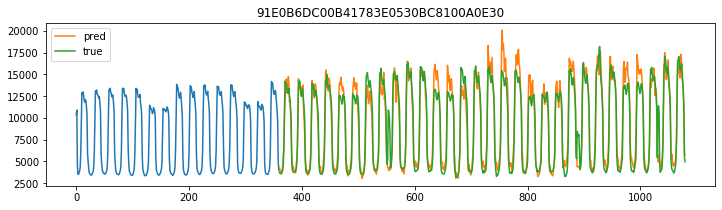

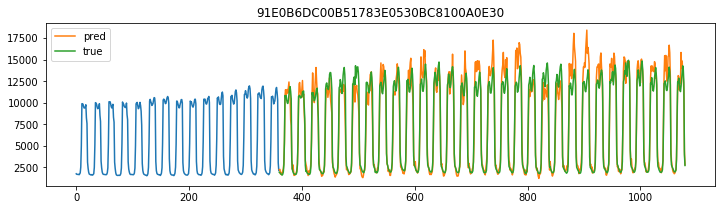

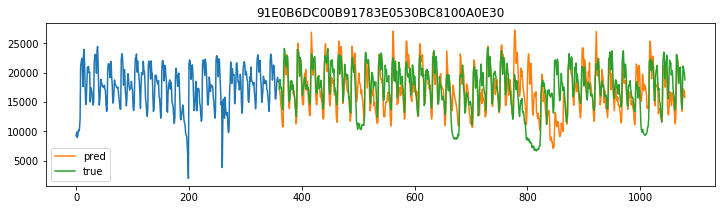

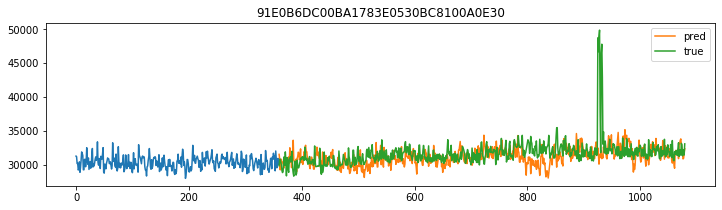

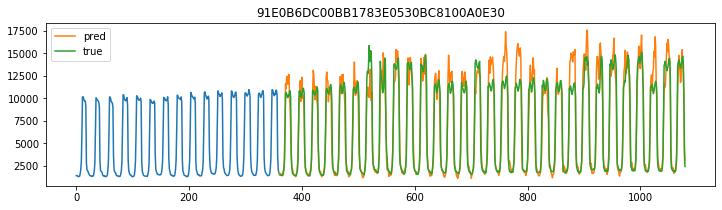

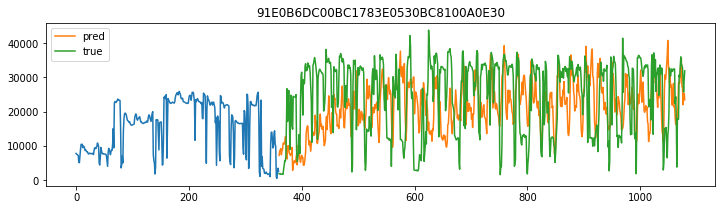

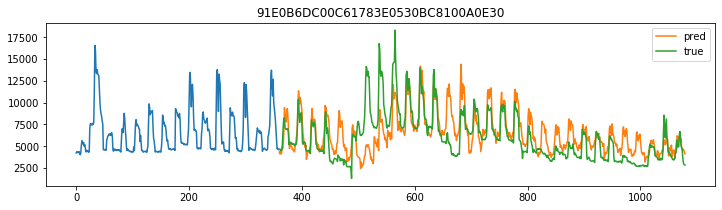

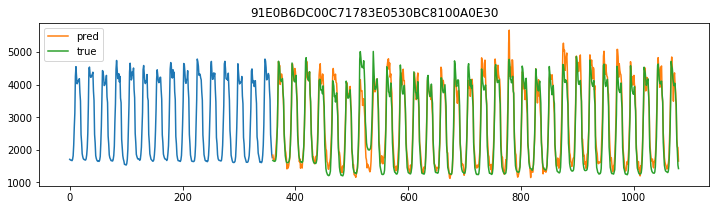

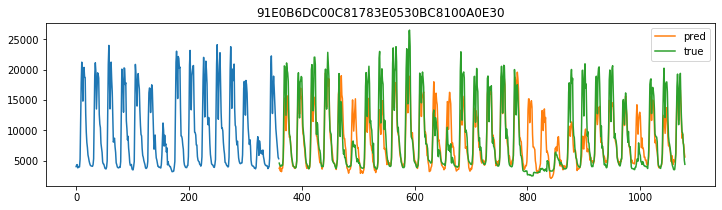

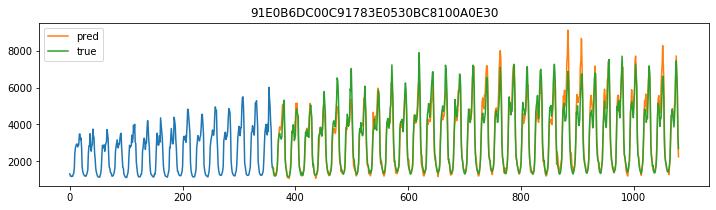

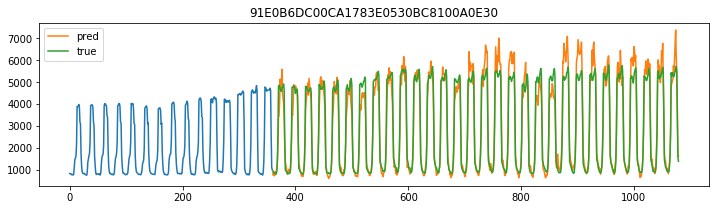

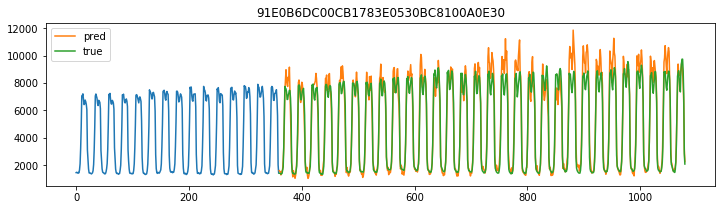

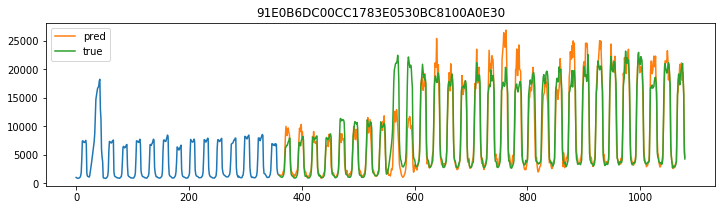

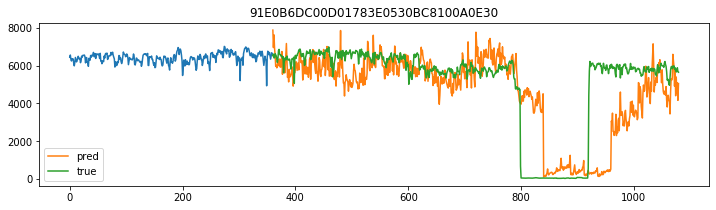

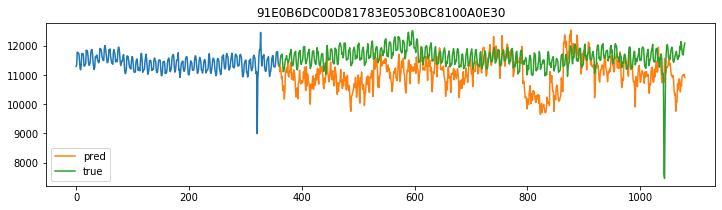

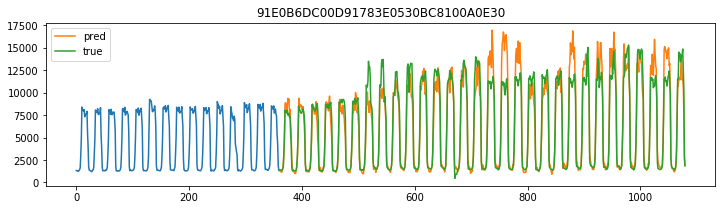

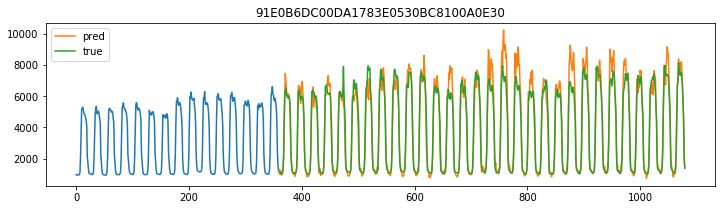

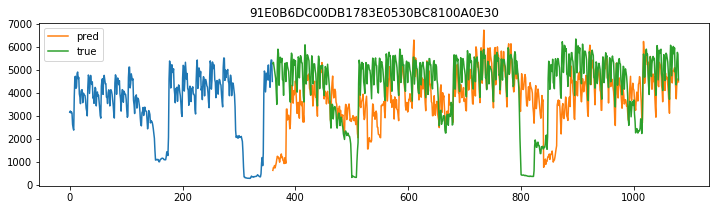

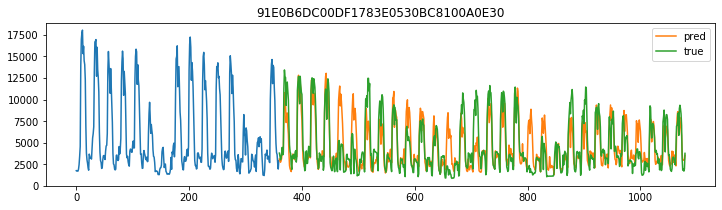

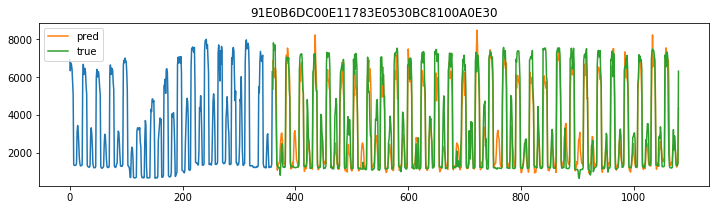

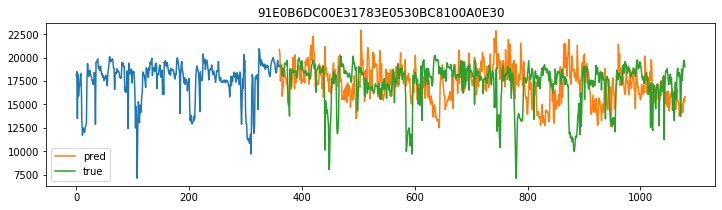

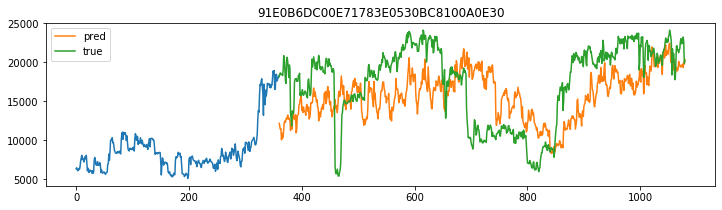

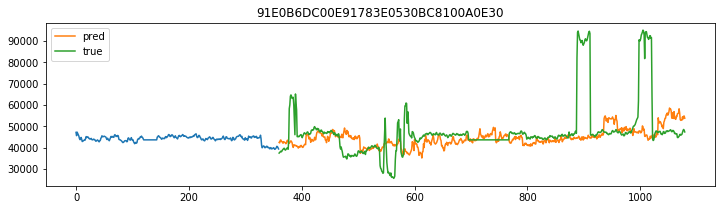

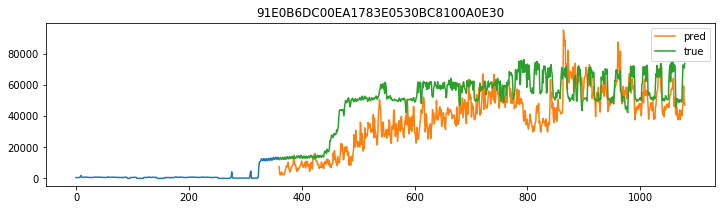

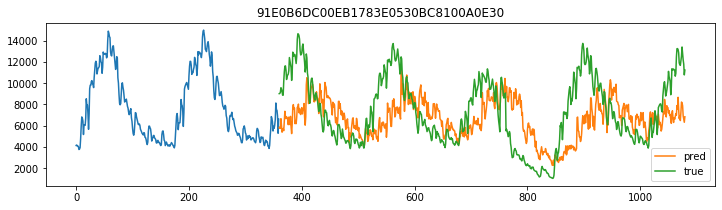

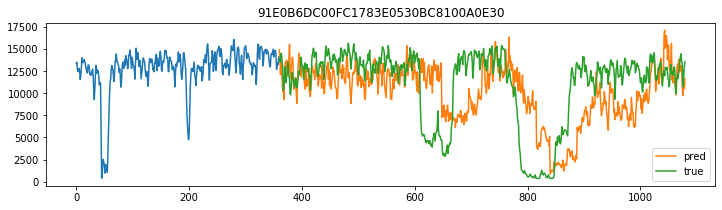

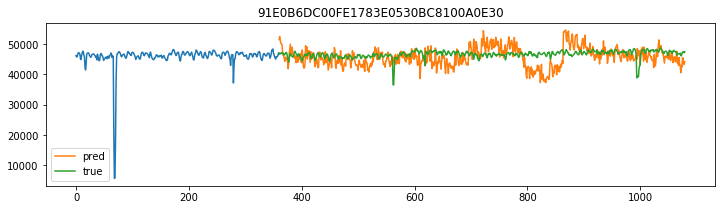

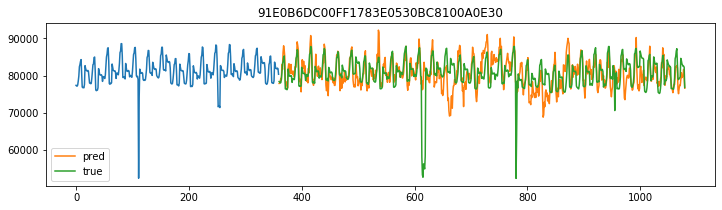

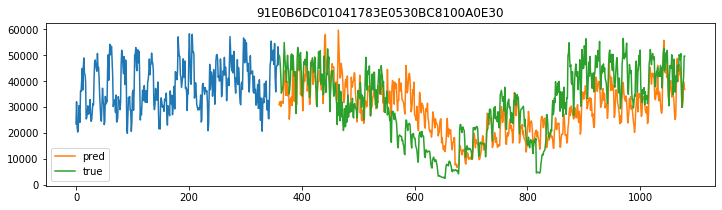

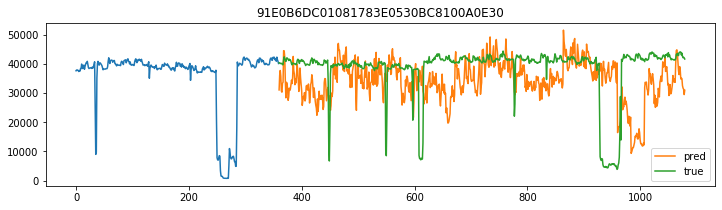

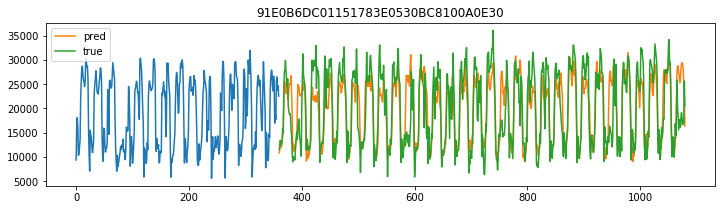

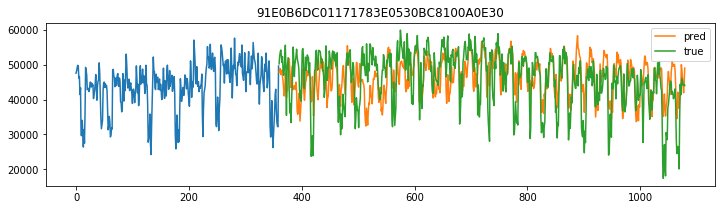

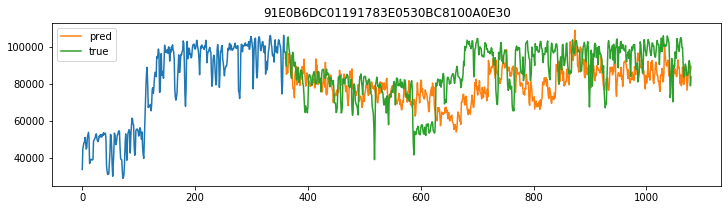

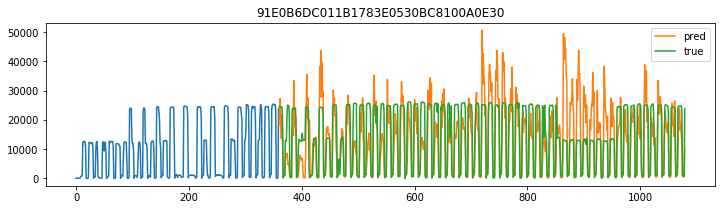

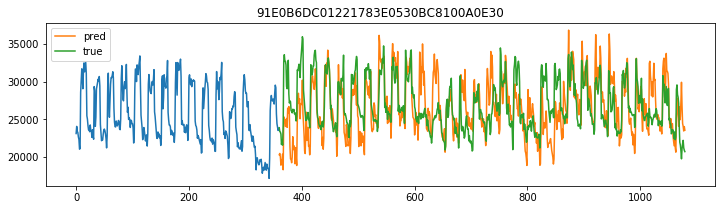

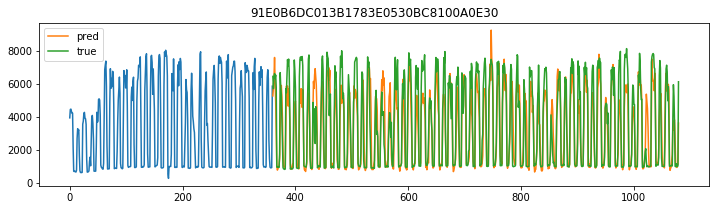

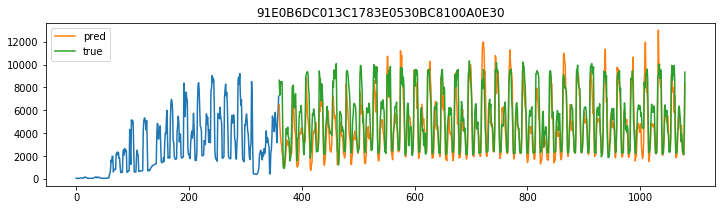

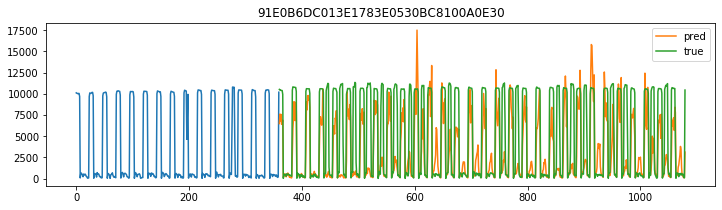

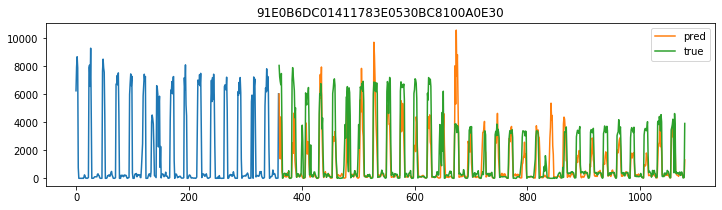

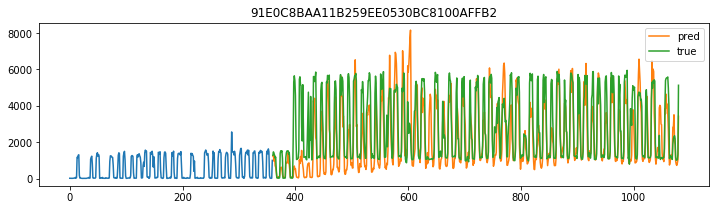

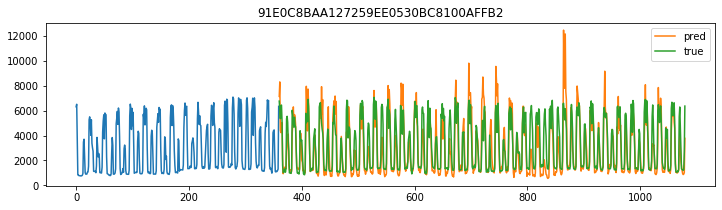

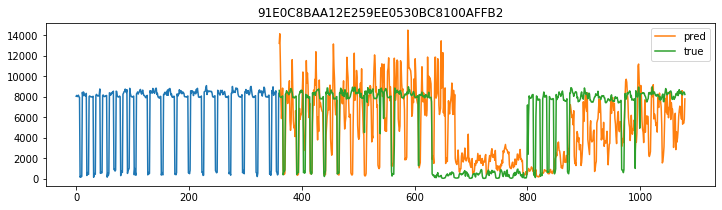

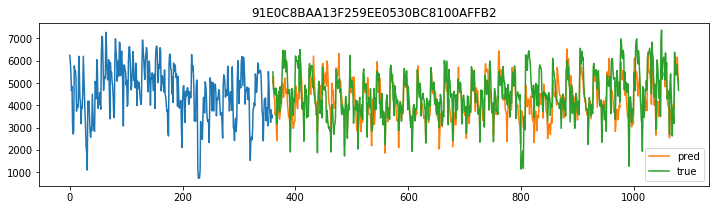

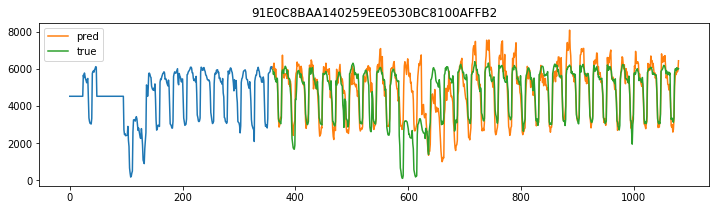

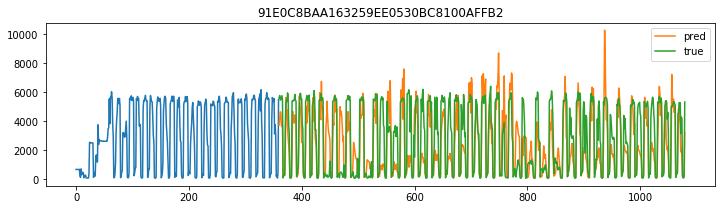

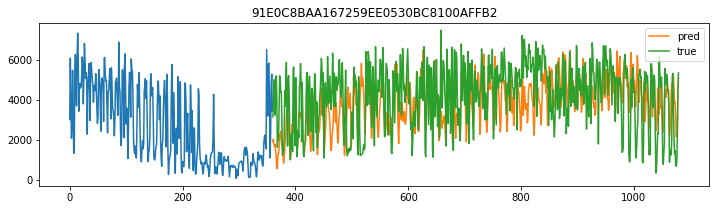

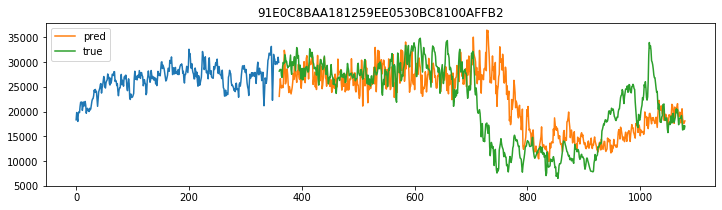

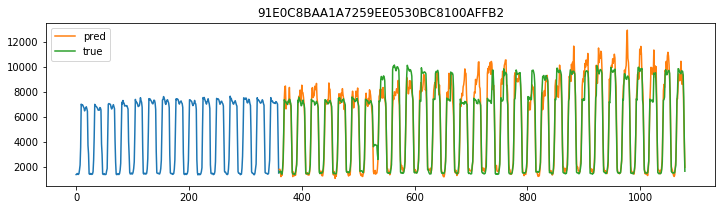

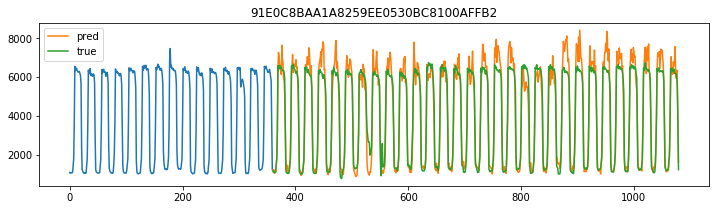

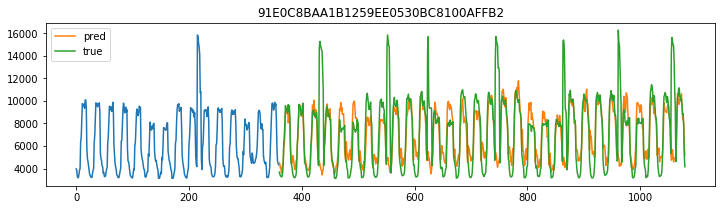

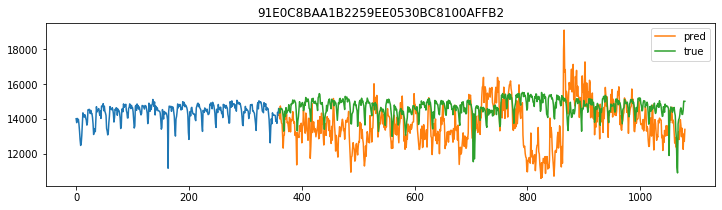

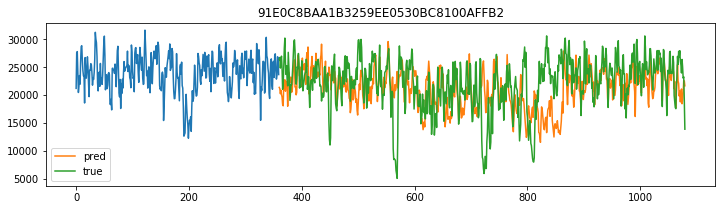

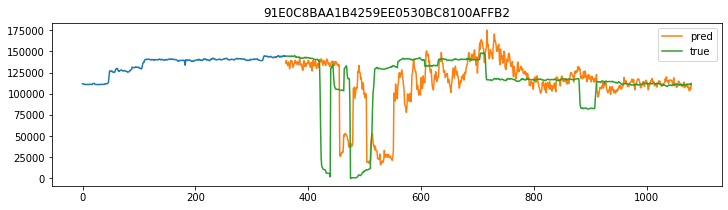

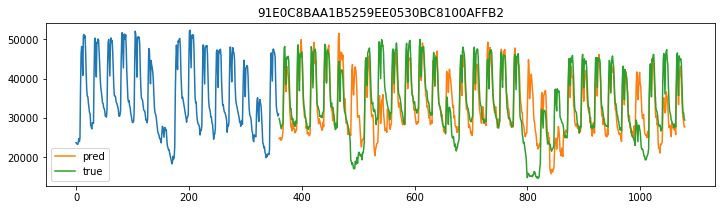

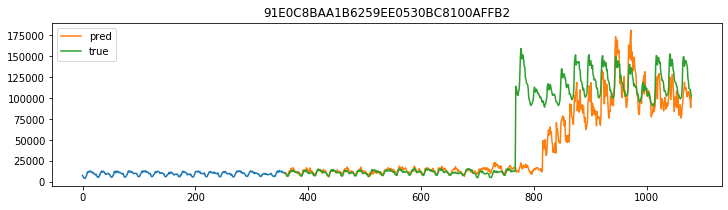

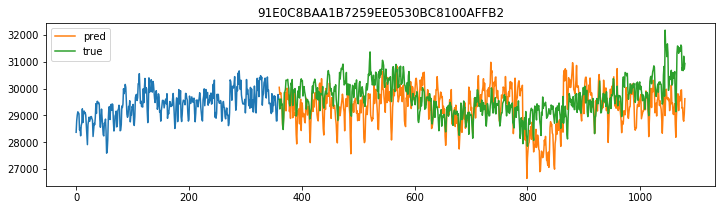

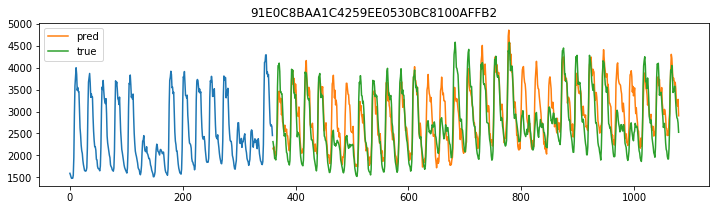

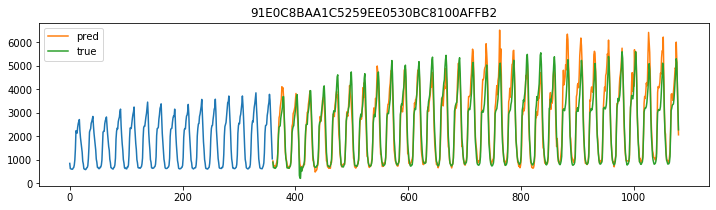

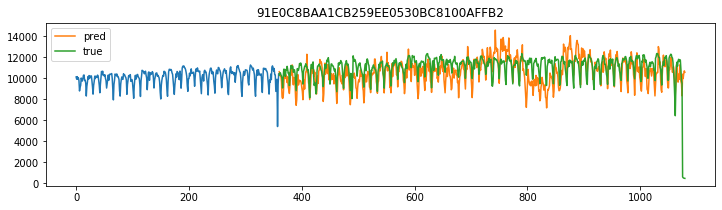

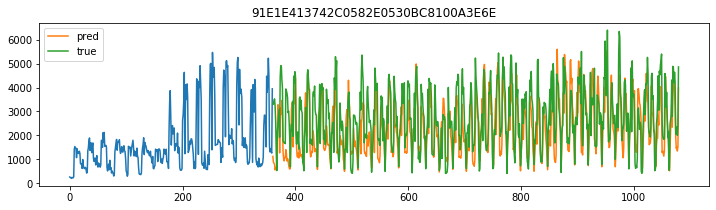

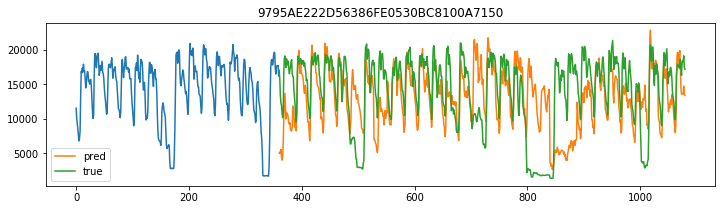

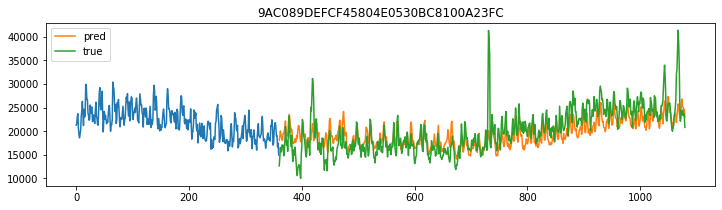

In [44]:
plot(x_true, y_true, y_pred)

In [31]:
scores.describe()

wave         v1
count  62.000000  62.000000
mean    0.337915   0.526637
std     0.609258   1.994470
min     0.026115   0.017290
25%     0.122940   0.089047
50%     0.175686   0.171180
75%     0.344694   0.306400
max     4.629118  15.607201

In [34]:
scores.sort_values('wave').tail(10)

wave         v1
91E0B6DC01041783E0530BC8100A0E30  0.423152   0.624030
91E0B6DC00BC1783E0530BC8100A0E30  0.452404   0.442014
91E0C8BAA163259EE0530BC8100AFFB2  0.462613   0.294976
91E0B6DC013E1783E0530BC8100A0E30  0.465381   0.311037
9795AE222D56386FE0530BC8100A7150  0.528765   0.420454
91E0B6DC01411783E0530BC8100A0E30  0.780475   0.876168
91E0B6DC00FC1783E0530BC8100A0E30  0.904531   1.263646
91E0C8BAA1B4259EE0530BC8100AFFB2  0.963050   1.114753
91E0C8BAA12E259EE0530BC8100AFFB2  1.567175   3.111139
91E0B6DC00D01783E0530BC8100A0E30  4.629118  15.607201

In [35]:
12/62

0.1935483870967742